In [1]:
%load_ext jupyter_black

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import os
import sys
import pandas as pd
import numpy as np
import requests
from spotify_dl import spotify_dl
from pathlib import Path
import time
import os
from dotenv import load_dotenv  # changed magic command to explicit load
import librosa
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import pairwise
from sklearn.model_selection import train_test_split
from typing import List
from flask import Flask, redirect, request
import random
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from skimage.transform import resize


pd.set_option("display.max_rows", None)  # pandas dataframe formatting options
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.2f}".format


custom_env_path = "../../brainstation_capstone_cfg.env"  # environment variables file

## Read in Existing Data

In [3]:
# Numpy MP3 directory: ../data/vectorized_mp3s/raw/
data_dir = Path("../data/vectorized_mp3s/raw/")
npy_glob = data_dir.rglob("*.npy")
file_paths = [file_path for file_path in npy_glob]

# Generate Track ID List
track_ids = []
for file_path in file_paths:
    track_id = str(file_path).split("_")[2].split(".")[0]
    track_ids.append(track_id)
track_ids = list(set(track_ids))  # removes the duplicates from list

In [4]:
height = 224
width = 224
channels = 3
for file_path in file_paths:
    if "1ZB2qWsheGabSEYvBYxjKn" in str(file_path):
        melspectrogram = np.load(
            f"../data/vectorized_mp3s/raw/melspectrogram_{track_id}.npy"
        )
        chroma = np.load(f"../data/vectorized_mp3s/raw/chroma_{track_id}.npy")
        tonnetz = np.load(f"../data/vectorized_mp3s/raw/tonnetz_{track_id}.npy")
        mel_resize = resize(melspectrogram, (height, width))
        chroma_resize = resize(chroma, (height, width))
        tonnetz_resize = resize(tonnetz, (height, width))
print("mel resize shape: ", mel_resize.shape)
print("chroma resize shape: ", chroma_resize.shape)
print("tonnetz resize shape: ", tonnetz_resize.shape)

mel resize shape:  (224, 224)
chroma resize shape:  (224, 224)
tonnetz resize shape:  (224, 224)


In [5]:
resize(melspectrogram, (224, 224)).shape

(224, 224)

In [6]:
# Bringing down the images to three dimensions, we can lose the MFCC since that is a component of the melspectrogram

In [7]:
len(track_ids)

11578

<Figure size 640x480 with 0 Axes>

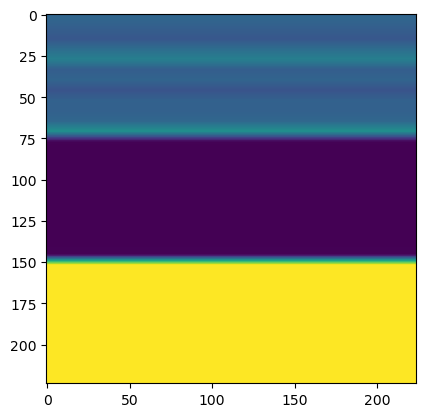

<Figure size 640x480 with 0 Axes>

In [20]:
layers = [mel_resize, chroma_resize, tonnetz_resize]
image_stack = []
for layer in layers:
    max_val = layer.max()
    min_val = layer.min()
    range = max_val - min_val
    norm = (layer - min_val) / range
    scaled = norm * 255.999
    as_int = scaled.astype(np.uint8)
    image_stack.append(as_int)
audio_rgb = np.dstack(image_stack)
plt.figure()
plt.imshow(audio_rgb[:, :, 1])
plt.figure()
# print(as_int)
# print("\n")
# print(layer.dtype)
# print(layer.max())
# print(layer.min())
# print("\n")

## Neural Network Implementation

In [ ]:
def set_random_seed(seed):
    
    '''Random seeds for reproducability'''
    
    random.seed(seed)
    tf.random.set_seed(seed)

In [ ]:
res_model = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(height,width,channels))
res_model.summary()